In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Application de la méthode de Galerkine aux données
"""

DataFolder="C:/Users/Julie_000/Desktop/Stage/Stage_l3"
#DataFolder="E:/Clément/Julie/Stage_L3"

In [2]:
from mat4py import loadmat #pour charger des .mat
import matplotlib
import matplotlib.pyplot as plt # pour tracer les figures
import os # pour modifier le dossier de travail
import numpy as np 
from pathlib import Path # Pour rendre les Path compatibles entre Mac et Windows
from matplotlib import rc #Les trois prochaines lignes pour que Ã§a ressemble Ã  latex
rc('font', size=16)
rc('text', usetex=True)
import scipy as sc
import matplotlib.cm as cm #colormaps
from matplotlib.colors import Normalize #Pour l'utilisation des couleurs dans quiver
from matplotlib.ticker import MaxNLocator #pour les courbes de niveau
from scipy.ndimage import gaussian_filter #Filtrage gaussien
import matplotlib.patches as mpatches #pour le nageur

from scipy.linalg import pinv as scpinv
from numpy.linalg import pinv as nppinv


from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve

import fonctions_projet_divergence as fpd#pour les données

colormap2=cm.PiYG#colormap

from mpl_toolkits.mplot3d import Axes3D#plot3D

In [3]:
def PIV(prof,manips): 
    """retourne les données des plans pour la bonne profondeur"""
    if prof==5:
        piv=manips['piv5']
    elif prof==10:
        piv=manips['piv10']
    elif prof==15:
        piv=manips['piv15']
    else:
        return("prof n'a pas une valeur acceptable")   
    return(piv)

def nb_plan(prof):
    "Détermine le nombre de plan pour une profondeur donnée"
    if prof==5:
        return(16)
    if prof==10:
        return(32)
    if prof==15:
        return(49)
    else:
        return("prof n'a pas une valeur acceptable")
    
def donnees(n,piv,size):
    "Charge les données pour la profondeur donnée"
    umo=np.zeros((n,size,size))
    vmo=np.zeros((n,size,size))
    ume=np.zeros((n,size,size))
    vme=np.zeros((n,size,size))
    uva=np.zeros((n,size,size))
    vva=np.zeros((n,size,size))
    cu=np.zeros((n,size,size))
    cv=np.zeros((n,size,size))
    x=np.zeros((n,size,size))
    y=np.zeros((n,size,size))
    z=np.zeros((n))

    for plan in range(n): 
            umo[plan]=np.array(piv[plan]['umoy'])
            vmo[plan]=np.array(piv[plan]['vmoy'])
            ume[plan]=np.array(piv[plan]['umed'])
            vme[plan]=np.array(piv[plan]['vmed'])
            uva[plan]=np.array(piv[plan]['uvar'])
            vva[plan]=np.array(piv[plan]['vvar'])
            cu[plan]=np.array(piv[plan]['cu'])
            cv[plan]=np.array(piv[plan]['cv'])
            x[plan]=np.array(piv[plan]['x'])
            y[plan]=np.array(piv[plan]['y'])
            z[plan]=np.array(piv[plan]['prof'])
    return(umo,vmo,ume,vme,uva,vva,cu,cv,x,y,z)

def conv(u,plan,variable_fixe):
    "Met les array sous la bonne forme"
    if np.ndim(u)==3:
        if variable_fixe=='x':
            return(np.transpose(u[:,:,plan]))
        elif variable_fixe=='y':
            return(np.transpose(u[:,plan,:]))
    elif np.ndim(u)==4:
        conv=np.zeros((np.shape(u)[0],size-1,P))
        if variable_fixe=='x':
            for i in range(np.shape(u)[0]):
                conv[i]=np.transpose(u[i,:,:,plan])
            return(conv)
        elif variable_fixe=='y':
            for i in range(np.shape(u)[0]):
                conv[i]=np.transpose(u[i,:,plan,:])
            return(conv)
        
def vitesse_nageur(prof):
    "donne la vitesse du nageur pour une profondeur. Elle est suivant ey"
    if prof==5:
        return(60)
    elif prof==10:
        return(59)
    elif prof==15:
        return(62)
    
    
def plot_champ_vitesse(u,v,x,y,title):
    "Fonction de tracé du champ de vitesse"
    #norme
    velocity=np.sqrt(u**2+v**2)
    velmax=np.mean(velocity)+3*np.std(velocity)#norme maximale représentée sur la colormap borne sup arbitraire
    colors = np.copy(velocity)
    colors[velocity>velmax]=velmax
    colormap=cm.magma#colormap je crois que cette commande ne fonctionne pas
    norm = Normalize()
    norm.autoscale(colors)

    #plot   
    fig,ax=plt.subplots(num=title)
    im=ax.quiver(x[::2,::2],y[::2,::2],u[::2,::2]/velocity[::2,::2],v[::2,::2]/velocity[::2,::2],colors[::2,::2])
    fig.colorbar(im, ax=ax)  #pour la barre de couleur
    
    fig.suptitle(title,fontsize=16)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()
    
    
def plot_divergence(div,dx,dy,title,vmin,vmax):
    "Tracé des divergences"
    #norme
    #dx=dx[20:80,30:90]
    #dy=dy[20:80,30:90]
    #div=div[20:80,30:90]
    norm=Normalize(vmin=vmin, vmax=vmax)
    levels = MaxNLocator(nbins=255).tick_values(vmin,vmax)
    
    fig, l0 = plt.subplots(num=title)
    im0 = l0.contourf(dx,dy,div,levels=levels, cmap=colormap2,norm=norm)
    fig.colorbar(im0,ax=l0)
    l0.set_xlabel('x')
    l0.set_ylabel('y')
    circle = mpatches.Circle((0,0), 6, color='snow')#patch
    l0.add_patch(circle)
   
    fig.tight_layout(pad = 3)
    fig.suptitle(title,fontsize=20)
    plt.show()
    
def divergence2D_astropy(u,v,x,y,sigma):
    "Applique le programme de divergence2D avec filtre gaussien sur la vitesse"
    unan=np.copy(u)
    vnan=np.copy(v)
    unan[u==0]=np.nan
    vnan[v==0]=np.nan
    #Filtrage
    # We smooth with a Gaussian kernel with x_stddev=1 (and y_stddev=1)
    # It is a 9x9 array
    kernel = Gaussian2DKernel(x_stddev=sigma,y_stddev=sigma)

    # astropy's convolution replaces the NaN pixels with a kernel-weighted
    # interpolation from their neighbors
    u_filtre = convolve(unan, kernel)
    v_filtre = convolve(vnan, kernel)

    
    #dérivation
    du_filtre,dv_filtre=fpd.deriv(u_filtre,x,1),fpd.deriv(v_filtre,y,0)
    dx=fpd.abcisse(x,1)
    dy=fpd.abcisse(y,0)
    #shape
    du_filtre,dv_filtre=fpd.good_shape(du_filtre),fpd.good_shape(dv_filtre)
    dx,dy=fpd.good_shape(dx),fpd.good_shape(dy)
    #somme
    div = fpd.somme(du_filtre,dv_filtre)
    #masque
    div_masque=fpd.masque(div,x,y,dx,dy)
    return(div_masque,dx,dy)

def methode_Galerkine_2(u,v,x,y,z,P,m,h):
    "Galerkine en ignorant les valeurs nulles"
    #divergence bidimensionelle
    div_2D=np.zeros((P,size-1,size-1))
    dx=np.zeros((P,size-1,size-1))
    dy=np.zeros((P,size-1,size-1))
    vz=np.zeros((P,size-1,size-1))
    dvz=np.zeros((P,size-1,size-1))

    for plan in range(P):
        div_2D[plan],dx[plan],dy[plan]=divergence2D_astropy(u[plan],v[plan],x[plan],y[plan],2)
    for i in range(size-1):
        for j in range(size-1):
            divij=div_2D[:,i,j]
            zcor=z[divij==divij] #False pour un NaN, True sinon
            divijcor=divij[divij==divij]
            pinv=nppinv(np.transpose(np.array([n*np.pi/h*np.cos(n*np.pi/h*zcor) for n in range(1,m+1)])))
            a=np.matmul(pinv,divijcor)
            sin=np.transpose(np.array([np.sin(n*np.pi*z/h) for n in range(1,m+1)]))
            dsin=np.transpose(np.array([n*np.pi/h*np.cos(n*np.pi*z/h) for n in range(1,m+1)]))

            a=np.reshape(a,(np.shape(a)[-1]))
            sin=np.reshape(sin,(np.shape(sin)[-2],np.shape(sin)[-1]))
            dsin=np.reshape(dsin,(np.shape(dsin)[-2],np.shape(dsin)[-1]))

            if len(zcor)>2*m:
                vz[:,i,j]=np.matmul(sin,a)
                dvz[:,i,j]=np.matmul(dsin,a)
            div_3D=div_2D+dvz
    return(vz,dvz,div_2D,div_3D)

In [4]:
prof=15 # Choisi sur quelle profondeur d'eau travailler (5, 10 ou 15 mm)

In [5]:
os.chdir(Path(DataFolder)) # se place dans le dossier où est rangée la manip
manips=loadmat('PIVnagseulall.mat') # Charge les données dans la variable manip

piv=PIV(prof,manips)#données pour la profondeur

P=nb_plan(prof)#nombre de plan dans la profondeur choisie
size=len(np.array(piv[0]['umoy']))

umo,vmo,ume,vme,uva,vva,cu,cv,x,y,z=donnees(P,piv,size)
print(np.shape(umo),np.shape(vmo),np.shape(x),np.shape(y),np.shape(z))
print(np.shape(piv))
v_nageur=vitesse_nageur(prof)

(49, 120, 120) (49, 120, 120) (49, 120, 120) (49, 120, 120) (49,)
(49,)


# Comparaison de différentes façons de traiter les résultats de PIV
En haut à gauche : moyenne
En haut à droite : médiane
En bas à gauche : moyenne avec des 0 là où il y a moins de 10% d'info
En bas à droite : moyenne avec des 0 là où l'écart-type est plus grand que le vecteur

In [6]:
print(np.shape(z))

(49,)


In [7]:
figsize=[8,5]
fontsize=20

In [8]:
%matplotlib notebook
plan=4
#plt.rcParams['figure.figsize'] = figsize # taille par défaut des figures qu'on trace
fig, axs = plt.subplots(figsize=figsize,num=r'Champ bidimensionnel de vitesse pour $z = {} $'.format(np.around(-z[plan],decimals=1)))



u=np.copy(umo[plan])
v=np.copy(vmo[plan])
cup=cu[plan]
cvp=cv[plan]
u[cup<=50]=0
v[cvp<=50]=0

#plot
f=3
velocity=np.sqrt(u**2+v**2)
velmax=np.mean(velocity)+3*np.std(velocity)#norme maximale représentée sur la colormap borne sup arbitraire
colors = np.copy(velocity)
colors[velocity>velmax]=velmax
norm = Normalize()
norm.autoscale(colors)
im=axs.quiver(x[plan,0:80:f,::f],y[plan,0:80:f,::f],u[0:80:f,::f]/velocity[0:80:f,::f],v[0:80:f,::f]/velocity[0:80:f,::f],colors[0:80:f,::f],headwidth=7)
axs.set_xlabel(r"$x (mm)$",fontsize=fontsize)
axs.set_ylabel(r"$y (mm)$",fontsize=fontsize)
circle = mpatches.Circle((0,0), 6, color='gainsboro')#patch
axs.add_patch(circle)
cbar=plt.colorbar(im,ax=axs)
cbar.set_label(r'$m\cdot s^{-1}$',fontsize=fontsize)
plt.show()

<IPython.core.display.Javascript object>

C:\Users\Julie_000\anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


# Divergence 2D

In [9]:
div_2Dc=np.zeros((P,size-1,size-1))
dxc=np.zeros((P,size-1,size-1))
dyc=np.zeros((P,size-1,size-1))
for plan in range(P):
    u=np.copy(umo[plan])
    v=np.copy(vmo[plan])
    cup=cu[plan]
    cvp=cv[plan]
    u[cup<=50]=np.nan
    v[cvp<=50]=np.nan
    div_2Dc[plan],dxc[plan],dyc[plan]=divergence2D_astropy(u,v,x[plan],y[plan],1)
    

In [10]:
print(np.shape(u))

(120, 120)


In [11]:
div_2Dc[div_2Dc!=div_2Dc]=0
print(np.shape(div_2Dc))
print(np.shape(dxc))

(49, 119, 119)
(49, 119, 119)


In [12]:
fig, axs = plt.subplots(figsize=figsize,num=r'Divergence bidimensionnelle pour $z = {} mm$'.format(np.around(-z[plan],decimals=1)))
plan=4
v=0.1

f3=axs.imshow(div_2Dc[plan],vmin=-v,vmax=v,cmap=colormap2)
axs.invert_yaxis()
cbar=plt.colorbar(f3, ax=axs)
cbar.set_label(r'$s^{-1}$',fontsize=fontsize)
circle = mpatches.Circle((60,60), 6, color='gainsboro')#patch
axs.add_patch(circle)
axs.set_xlabel(r"$x (mm)$",fontsize=fontsize)
axs.set_ylabel(r"$y (mm)$",fontsize=fontsize)
plt.plot()




<IPython.core.display.Javascript object>

[]

## Superposition

Pas sûre qu'on puisse le faire avec Imshow ?

In [13]:
def plot_superposition(div,u,v,x,y,title):
    "Tracé des divergences superposées avec le champ de vitesse"
    #norme divergence
    
    fig, l0 = plt.subplots(num=title,figsize=(8,5))
    
    
    #plot divergence
    f3=axs.imshow(div[plan],vmin=-v,vmax=v,cmap=colormap2)
    axs.invert_yaxis()
    cbar=plt.colorbar(f3, ax=axs)
    cbar.set_label(r'$s^{-1}$',fontsize=fontsize)
    
    
    #plot champ vitesse
    f=3
    velocity=np.sqrt(u**2+v**2)
    velmax=np.mean(velocity)+3*np.std(velocity)#norme maximale représentée sur la colormap borne sup arbitraire
    colors = np.copy(velocity)
    colors[velocity>velmax]=velmax
    norm = Normalize()
    norm.autoscale(colors)
    im=axs.quiver(x[plan,0:80:f,::f],y[plan,0:80:f,::f],u[0:80:f,::f]/velocity[0:80:f,::f],v[0:80:f,::f]/velocity[0:80:f,::f],colors[0:80:f,::f],headwidth=7)
    axs.set_xlabel(r"$x (mm)$",fontsize=fontsize)
    axs.set_ylabel(r"$y (mm)$",fontsize=fontsize)
    cbar=plt.colorbar(im,ax=axs)
    cbar.set_label(r'$m\cdot s^{-1}$',fontsize=fontsize)
    
    circle = mpatches.Circle((60,60), 6, color='gainsboro')#patch
    axs.add_patch(circle)
    
    l0.set_xlabel(r"$x (mm)$",fontsize=fontsize)
    l0.set_ylabel(r"$y (mm)$",fontsize=fontsize)
    plt.show()

In [14]:
#plot_superposition(div_2Dc,u,v,x,y,'superposition')

# Galerkine

In [15]:
m=15


u=np.copy(umo)
v=np.copy(vmo)
u[cu<=50]=np.nan
v[cv<=50]=np.nan
vzc,dvzc,div2dc,div3dc=methode_Galerkine_2(u,v,x,y,z,P,m,prof)
u0=np.copy(u)
v0=np.copy(v)
x0=np.copy(x)
y0=np.copy(y)
print(np.shape(u))

(49, 120, 120)


In [16]:
print(np.shape(vzc))
xmax=np.shape(vzc)[1]
#tableau des z:
z=np.reshape(z,(P,1))
z_2D=np.hstack((z,z))
for i in range(xmax-2):
    z_2D=np.hstack((z_2D,z))
print(np.shape(z_2D))
print(np.shape(vzc))

(49, 119, 119)
(49, 119)
(49, 119, 119)


In [17]:
def colonne(u,plan,axe):
    #if variable_fixe=='x':
    v=np.copy(u)
    if axe==0:
        if plan==28:
            v[28:31,:]=0
        elif 29<=plan<=30:
            v[27:33,:]=0
        elif plan==32:
            v[28:31,:]=0
    elif axe==1:     
        if plan==28:
            v[:,28:31]=0
        elif 29<=plan<=30:
            v[:,27:33]=0
        elif plan==32:
            v[:,28:31]=0
    return(v)

def plot_champ_vitessez(u,v,x,y,title,xlabel,ylabel,plan):
    "Fonction de tracé du champ de vitesse 2D"
    f=2
    u1=np.copy(u)[::f,::f]
    v1=np.copy(v)[::f,::f]
    x1=np.copy(x)[::f,::f]
    y1=np.copy(y)[::f,::f]
    velocity1=np.sqrt(u1**2+v1**2)
    velmax1=np.mean(velocity1)+3*np.std(velocity1)#norme maximale représentée sur la colormap borne sup arbitraire
    colors1 = np.copy(velocity1)
    colors1[velocity1>velmax1]=velmax1
   
    norm = Normalize()
    norm.autoscale(colors1)
    
    #plot   
    fig,ax=plt.subplots(num=title,figsize=figsize)
    im=ax.quiver(x1,y1,u1/velocity1,v1/velocity1,colors1,cmap=plt.cm.rainbow,scale=40,headwidth=6)
    cbar=plt.colorbar(im,ax=ax)
    cbar.set_label(r'$v/v_{nageur}$',fontsize=fontsize)
    ax.set_xlabel(xlabel,fontsize=fontsize)
    ax.set_ylabel(ylabel,fontsize=fontsize)
    
    fig.suptitle(title,fontsize=16)
    plt.tight_layout(pad=3)
    plt.show()

In [18]:
print(np.shape(vzc))
u1=u0[:,:-1,:-1]
v1=v0[:,:-1,:-1]

(49, 119, 119)


C:\Users\Julie_000\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater


<IPython.core.display.Javascript object>


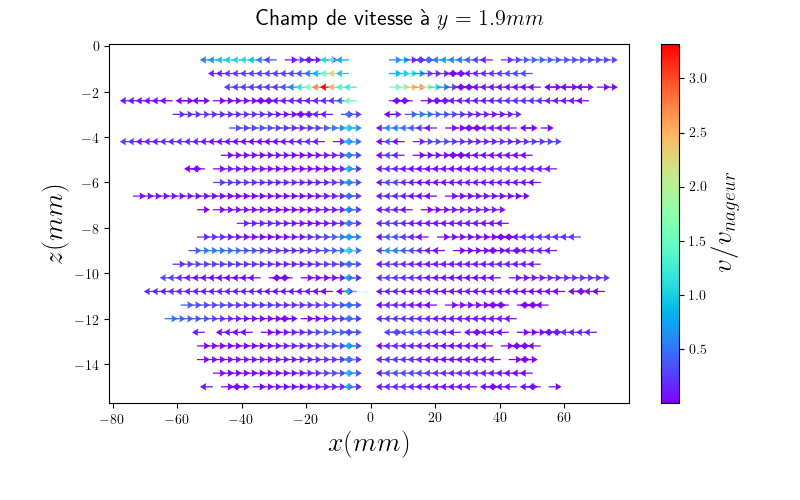

In [30]:
y_plan=61
plot_champ_vitessez(np.transpose(u0[:,y_plan,:]),np.transpose(vzc[:,y_plan,:]),np.transpose(x[:,y_plan,:]), -np.transpose(z_2D),r'Champ de vitesse à $y = {} mm$'.format(np.around(y[0,y_plan,0],decimals=1)),r'$x (mm)$',r'$z (mm)$',y_plan)

C:\Users\Julie_000\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater


<IPython.core.display.Javascript object>


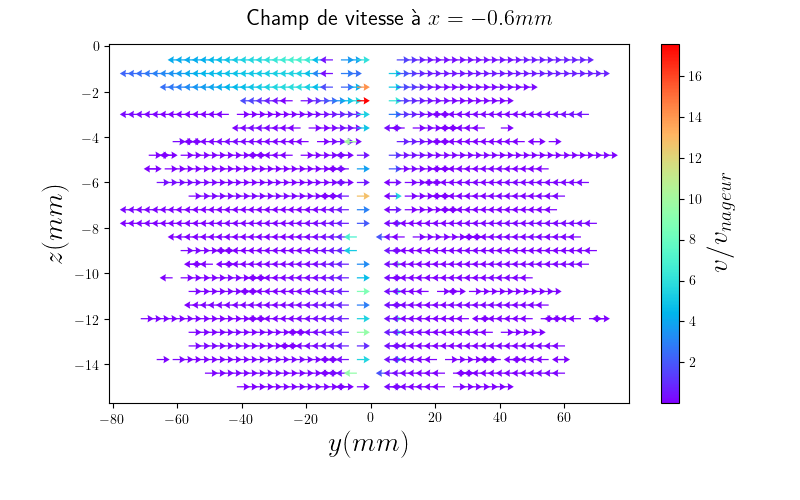

In [33]:
x_plan=59
plot_champ_vitessez(np.transpose(v0[:,:,x_plan]),np.transpose(vzc[:,:,x_plan]),np.transpose(y[:,:,x_plan]), -np.transpose(z_2D),r'Champ de vitesse à $x = {} mm$'.format(np.around(x[0,0,x_plan],decimals=1)),r'$y (mm)$',r'$z (mm)$',x_plan)

## Affichage de div 3D pour un plan (x,y) dans les 4 cas

In [ ]:
fig, axs = plt.subplots(figsize=figsize)
plan=10
v=1
f3=axs.imshow(div3dc[plan],vmin=-v,vmax=v,cmap=colormap2)
axs.invert_yaxis()
cbar=plt.colorbar(f3, ax=axs)
cbar.set_label(r'$s^{-1}$',fontsize=fontsize)
circle = mpatches.Circle((60,60), 6, color='gainsboro')#patch
axs.add_patch(circle)
axs.set_xlabel(r"$x (mm)$",fontsize=fontsize)
axs.set_ylabel(r"$y (mm)$",fontsize=fontsize)

## Ecart relatif entre dvz et div2d pour évaluer la réussite

In [ ]:
plan=15
d2dc=np.copy(div2dc)
d2dc[d2dc==0]=np.nan

fig, axs = plt.subplots(figsize=figsize)

f3=axs.imshow(np.abs((dvzc[plan]-d2dc[plan])/d2dc[plan]),vmin=0,vmax=1,cmap=colormap2)
axs.invert_yaxis()
cbar=plt.colorbar(f3, ax=axs)
cbar.set_label(r'$s^{-1}$',fontsize=fontsize)
circle = mpatches.Circle((60,60), 6, color='gainsboro')#patch
axs.add_patch(circle)
axs.set_xlabel(r"$x (mm)$",fontsize=fontsize)
axs.set_ylabel(r"$y (mm)$",fontsize=fontsize)


# Comparaison entre dvz et div2D pour des points (i,j) et un nombre de modes m choisis

In [ ]:
print(np.shape(u0))


In [ ]:
z=np.linspace(0,prof,P)
vz,dvz,div_2D,div_3D=methode_Galerkine_2(u0,v0,x0,y0,z,P,m,prof)


In [ ]:
print(np.shape(div_2D))

In [ ]:
m=15
i=50
j=65
divij=div_2D[:,i,j]
zcor=z[divij==divij] #False pour un NaN, True sinon
divijcor=divij[divij==divij]
plt.plot(zcor,divijcor,'+b',label=r'$\mathrm{div_{2D}}$')
plt.plot(z,dvz[:,i,j],'-r',label=r'$\partial_{z} v_{z}$')
plt.xlabel(r'$\SI{z}{mm}$', fontsize=fontsize)
plt.ylabel(r'$s^{-1}$', fontsize=fontsize)
plt.legend()
plt.show()

In [ ]:
m=15
i=40
j=55
divij=div_2D[:,i,j]
zcor=z[divij==divij] #False pour un NaN, True sinon
divijcor=divij[divij==divij]
plt.plot(zcor,divijcor,'+b',label=r'\mathrm{div_{2D}')
plt.plot(z,dvz[:,i,j],'-r',label=r'\partial_{z} v_{z}')
plt.xlabel(r'$\SI{z}{mm}$', fontsize=fontsize)
plt.ylabel(r'$s^{-1}$', fontsize=fontsize)
plt.legend()
plt.show()